In [2]:
import sys
print(sys.executable)

c:\Program Files\Python312\python.exe


In [3]:
import pandas as pd
df=pd.read_csv('../../data/resultado.csv', sep=';', quotechar='"', low_memory=False)

In [4]:
# Exibir os nomes das colunas
print("Nomes das colunas no dataset:")
print(df.columns.tolist())

Nomes das colunas no dataset:
['sintomas', 'profissionalSaude', 'racaCor', 'outrosSintomas', 'outrasCondicoes', 'profissionalSeguranca', 'cbo', 'condicoes', 'sexo', 'estado', 'estadoIBGE', 'municipio', 'municipioIBGE', 'origem', 'estadoNotificacao', 'municipioNotificacao', 'municipioNotificacaoIBGE', 'evolucaoCaso', 'classificacaoFinal', 'codigoEstrategiaCovid', 'codigoBuscaAtivaAssintomatico', 'outroBuscaAtivaAssintomatico', 'codigoTriagemPopulacaoEspecifica', 'outroTriagemPopulacaoEspecifica', 'codigoLocalRealizacaoTestagem', 'outroLocalRealizacaoTestagem', 'codigoRecebeuVacina', 'codigoLaboratorioPrimeiraDose', 'codigoLaboratorioSegundaDose', 'lotePrimeiraDose', 'loteSegundaDose', 'codigoContemComunidadeTradicional', 'source_id', 'excluido', 'validado', 'codigoDosesVacina', 'estadoNotificacaoIBGE', 'totalTestesRealizados', 'dataNotificacao', 'dataInicioSintomas', 'dataEncerramento', 'dataPrimeiraDose', 'dataSegundaDose', 'codigoEstadoTeste1', 'codigoTipoTeste1', 'codigoFabricanteTes

In [5]:
# Padronizar os valores da coluna 'estadoNotificacaoIBGE' que contém os estados (remover espaços e converter para maiúsculas)
df['estadoNotificacaoIBGE'] = df['estadoNotificacaoIBGE'].str.strip().str.upper()

In [6]:
# Deixar na base apenas os estados a serem estudados
estados_selecionados = ['PR', 'SC', 'PA', 'TO', 'SP', 'ES', 'GO', 'MS', 'BA', 'SE']
df_final = df[df['estadoNotificacaoIBGE'].isin(estados_selecionados)]

In [7]:
#Função para padronizar os valores das colunas 'dataColetaTeste1' e	'dataColetaTeste2' que contém as datas das vacinações para datetime

from datetime import datetime

def converte_data(data):
  if isinstance(data, str): # Verifica se o valor é uma string
    for formato in ('%Y-%m-%d', '%d/%m/%Y'):
        try:
            return datetime.strptime(data, formato)
        except ValueError:
            pass
    raise ValueError('no valid date format found')
  else:
        return pd.NaT # Retorna NaT (Not a Time) para valores não string

df_final['dataColetaTeste1'] = df_final['dataColetaTeste1'].apply(converte_data)
df_final['dataColetaTeste2'] = df_final['dataColetaTeste2'].apply(converte_data)

df_final.dtypes #Confere se ambas as colunas foram padronizadas para datetime


C:\Users\kmhar\AppData\Local\Temp\ipykernel_12720\910997809.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['dataColetaTeste1'] = df_final['dataColetaTeste1'].apply(converte_data)
C:\Users\kmhar\AppData\Local\Temp\ipykernel_12720\910997809.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['dataColetaTeste2'] = df_final['dataColetaTeste2'].apply(converte_data)


sintomas                     object
profissionalSaude            object
racaCor                      object
outrosSintomas               object
outrasCondicoes              object
                          ...      
dataColetaTeste1     datetime64[ns]
dataColetaTeste2     datetime64[ns]
dataColetaTeste3             object
dataColetaTeste4             object
idade                       float64
Length: 64, dtype: object

In [8]:
#Remove do dataframe os casos cujo ambas as datas são nulas
df_final = df_final.dropna(axis=0, how='all', subset=['dataColetaTeste1', 'dataColetaTeste2'])

In [9]:
#Remove valores menores que 2020
df_final = df_final[df_final['dataColetaTeste1'].dt.year >= 2020]

In [10]:
#Converte colunas 'codigoResultadoTeste1' e 'codigoResultadoTeste2' para numérico
df_final['codigoResultadoTeste1'] = pd.to_numeric(df_final['codigoResultadoTeste1'], errors='coerce')
df_final['codigoResultadoTeste2'] = pd.to_numeric(df_final['codigoResultadoTeste2'], errors='coerce')

In [11]:
#Filtrar os casos que obtiveram confirmação de COVID

#Filtrar dataframe para ter apenas as variáveis de interesse
df_final = df_final[['dataColetaTeste1', 'dataColetaTeste2', 'codigoResultadoTeste1', 'codigoResultadoTeste2', 'estadoNotificacaoIBGE']].dropna()

#Cria marcação de covid na linha
df_final['Covid'] = ((df_final['codigoResultadoTeste1']==1) | (df_final['codigoResultadoTeste2']==1)).astype(int)

#Deixa casos onde COVID = 1
#df_final = df_final[df_final['Covid'] == 1]

In [12]:
#Criar a contagem de quantidade de casos de COVID

#Filtrar dataframe para ter apenas as variáveis de interesse
df_final_primeira = df_final[['dataColetaTeste1', 'codigoResultadoTeste1', 'estadoNotificacaoIBGE']]
df_final_segunda = df_final[['dataColetaTeste2', 'codigoResultadoTeste2', 'estadoNotificacaoIBGE']]

#Deixa casos onde COVID = 1 de cada base
#df_final_primeira = df_final_primeira[df_final_primeira['codigoResultadoTeste1'] == 1]
#df_final_segunda = df_final_segunda[df_final_segunda['codigoResultadoTeste2'] == 1]

#Contar casos de COVID por data (primeira dose)
casos_primeira_dose = df_final_primeira.value_counts().reset_index()
casos_primeira_dose.columns = ['dataColetaTeste', 'resultadoTeste', 'Estado IBGE','Contaminados COVID']
casos_primeira_dose.head()

#Contar casos de COVID por data (segunda dose)
casos_segunda_dose = df_final_segunda.value_counts().reset_index()
casos_segunda_dose.columns = ['dataColetaTeste','resultadoTeste', 'Estado IBGE','Contaminados COVID']
casos_segunda_dose.head()

#Converter coluna 'Contaminados COVID' para númerico
casos_primeira_dose['Contaminados COVID'] = pd.to_numeric(casos_primeira_dose['Contaminados COVID'], errors='coerce')
casos_segunda_dose['Contaminados COVID'] = pd.to_numeric(casos_segunda_dose['Contaminados COVID'], errors='coerce')

#Filtrar dataframes novamente para retirar o resultado para ter apenas as variáveis de interesse
casos_primeira_dose = casos_primeira_dose[['dataColetaTeste', 'Estado IBGE','Contaminados COVID']]
casos_segunda_dose = casos_segunda_dose[['dataColetaTeste', 'Estado IBGE','Contaminados COVID']]

#Unir as duas contagens em um único DataFrame (concatenando para não perder valores)
agrupado = [casos_primeira_dose, casos_segunda_dose]
casos_total = pd.concat(agrupado)


In [13]:
casos_total.to_csv('/content/gdrive/My Drive/Mackenzie/casos_total.csv', index=False)

OSError: Cannot save file into a non-existent directory: '\content\gdrive\My Drive\Mackenzie'

In [ ]:
#Separar os casos para criar as novas colunas
pr = casos_total[casos_total['Estado IBGE'] == 'PR']
pa = casos_total[casos_total['Estado IBGE'] == 'PA']
sp = casos_total[casos_total['Estado IBGE'] == 'SP']
go = casos_total[casos_total['Estado IBGE'] == 'GO']
ba = casos_total[casos_total['Estado IBGE'] == 'BA']
sc = casos_total[casos_total['Estado IBGE'] == 'SC']
to = casos_total[casos_total['Estado IBGE'] == 'TO']
es = casos_total[casos_total['Estado IBGE'] == 'ES']
ms = casos_total[casos_total['Estado IBGE'] == 'MS']
se = casos_total[casos_total['Estado IBGE'] == 'SE']

#Excluir a coluna de nome dos estados
pr = pr[['dataColetaTeste', 'Contaminados COVID']]
pa = pa[['dataColetaTeste', 'Contaminados COVID']]
sp = sp[['dataColetaTeste', 'Contaminados COVID']]
go = go[['dataColetaTeste', 'Contaminados COVID']]
ba = ba[['dataColetaTeste', 'Contaminados COVID']]
sc = sc[['dataColetaTeste', 'Contaminados COVID']]
to = to[['dataColetaTeste', 'Contaminados COVID']]
es = es[['dataColetaTeste', 'Contaminados COVID']]
ms = ms[['dataColetaTeste', 'Contaminados COVID']]
se = se[['dataColetaTeste', 'Contaminados COVID']]

#Renomear a coluna de casos com os nomes dos estados
pr.rename(columns={'Contaminados COVID': 'PR'}, inplace=True)
pa.rename(columns={'Contaminados COVID': 'PA'}, inplace=True)
sp.rename(columns={'Contaminados COVID': 'SP'}, inplace=True)
go.rename(columns={'Contaminados COVID': 'GO'}, inplace=True)
ba.rename(columns={'Contaminados COVID': 'BA'}, inplace=True)
sc.rename(columns={'Contaminados COVID': 'SC'}, inplace=True)
to.rename(columns={'Contaminados COVID': 'TO'}, inplace=True)
es.rename(columns={'Contaminados COVID': 'ES'}, inplace=True)
ms.rename(columns={'Contaminados COVID': 'MS'}, inplace=True)
se.rename(columns={'Contaminados COVID': 'SE'}, inplace=True)

#Unir as os grupos de mais e menos populosos
casos_mais_pop = pd.concat([pr, pa, sp, go, ba])
casos_menos_pop = pd.concat([sc, to, es, ms, se])


<ipython-input-20-4c119aee1b50>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pr.rename(columns={'Contaminados COVID': 'PR'}, inplace=True)
<ipython-input-20-4c119aee1b50>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pa.rename(columns={'Contaminados COVID': 'PA'}, inplace=True)
<ipython-input-20-4c119aee1b50>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp.rename(columns={'Contaminados COVID': 'SP'}, inplace=True)
<ipytho

In [ ]:
casos_menos_pop.to_csv('/content/gdrive/My Drive/Mackenzie/casos_menos_pop.csv', index=False)

In [ ]:
casos_mais_pop.to_csv('/content/gdrive/My Drive/Mackenzie/casos_mais_pop.csv', index=False)

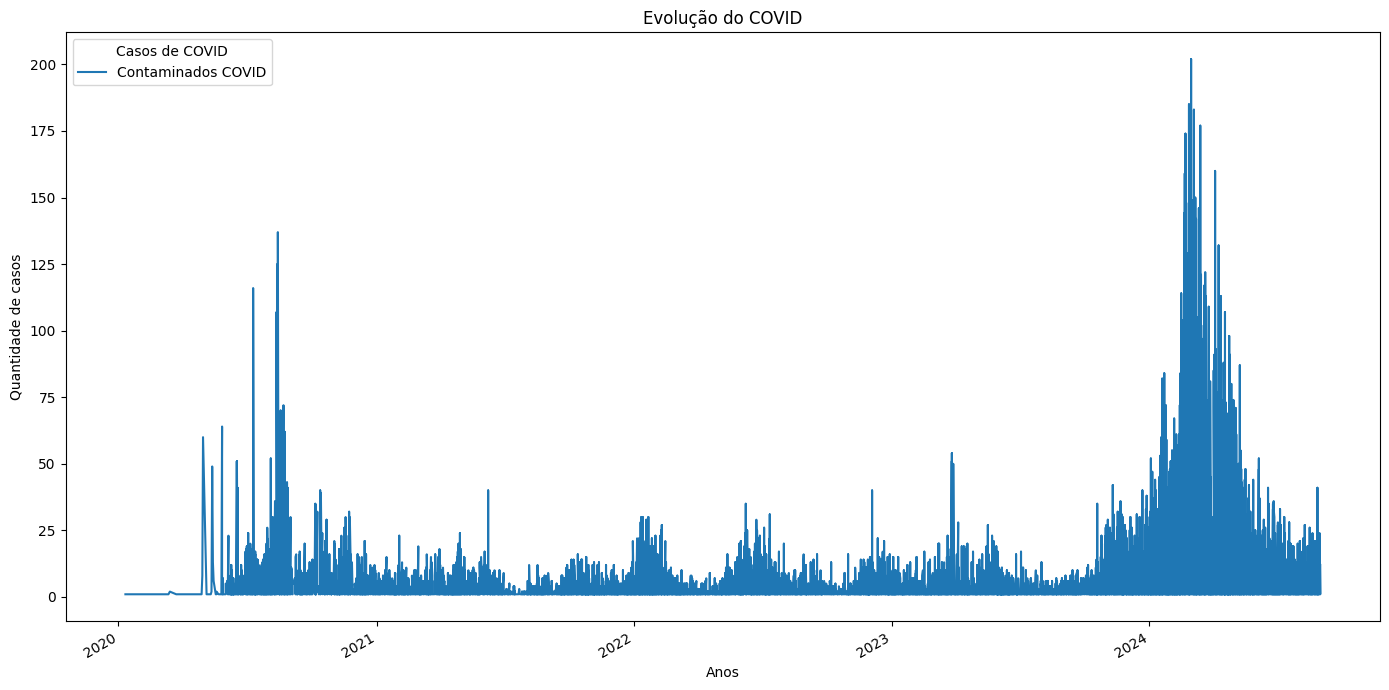

In [ ]:
#Visão total dos casos de COVID

import matplotlib.pyplot as plt
import seaborn as sns

casos_total.plot(x='dataColetaTeste', y='Contaminados COVID', figsize=(14, 7), linestyle="-")
plt.title('Evolução do COVID')
plt.xlabel('Anos')
plt.ylabel('Quantidade de casos')
plt.xticks(rotation=45)
plt.legend(title='Casos de COVID')
plt.tight_layout()

# Exibir o gráfico
plt.show()


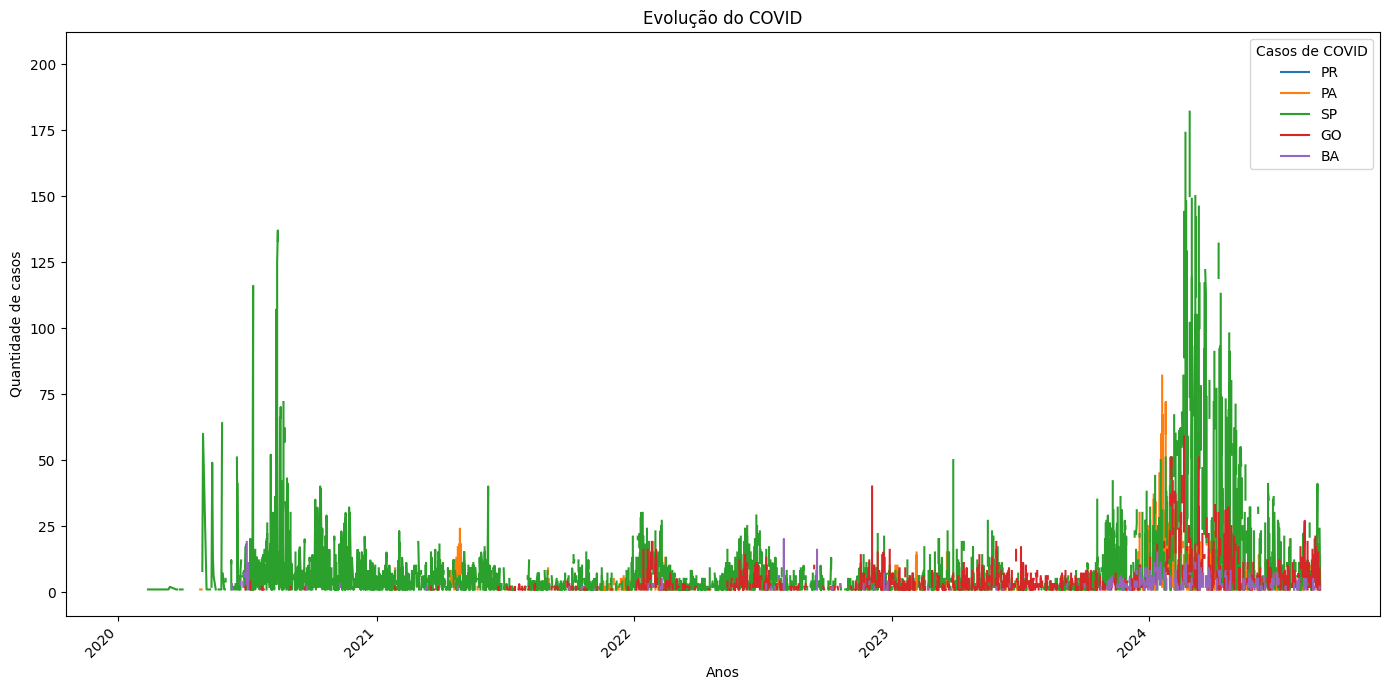

In [ ]:
#Visão por estados mais populosos dos casos de COVID
import matplotlib.pyplot as plt
import seaborn as sns

casos_mais_pop.plot(x='dataColetaTeste', y=['PR', 'PA', 'SP', 'GO', 'BA'], kind='line', figsize=(14, 7), linestyle="-")
plt.title('Evolução do COVID')
plt.xlabel('Anos')
plt.ylabel('Quantidade de casos')
plt.xticks(rotation=45)
plt.legend(title='Casos de COVID')
plt.tight_layout()

# Exibir o gráfico
plt.show()

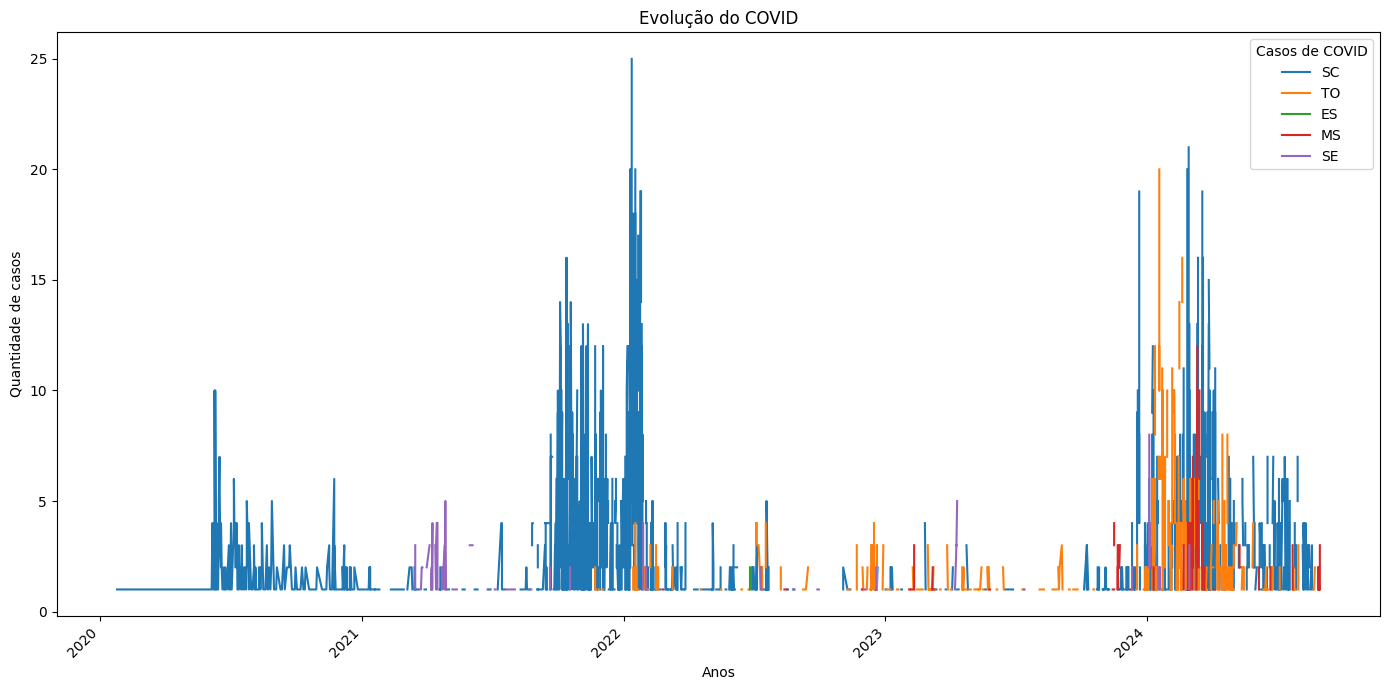

In [ ]:
#Visão por estados menos populosos dos casos de COVID
import matplotlib.pyplot as plt
import seaborn as sns

casos_menos_pop.plot(x='dataColetaTeste', y=['SC', 'TO', 'ES', 'MS', 'SE'], figsize=(14, 7), linestyle="-")
plt.title('Evolução do COVID')
plt.xlabel('Anos')
plt.ylabel('Quantidade de casos')
plt.xticks(rotation=45)
plt.legend(title='Casos de COVID')
plt.tight_layout()

# Exibir o gráfico
plt.show()